In [1261]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols
import math 
import matplotlib.pyplot as plt
from tbats import TBATS
%matplotlib inline

In [1380]:
df = pd.read_csv('https://raw.githubusercontent.com/minotaur142/dsc-v2-mod1-final-project-nyc-ds-060319/master/kc_house_data.csv')


In [281]:
df.zipcode.head()

0    98178
1    98125
2    98028
3    98136
4    98074
Name: zipcode, dtype: object

In [1381]:
#convert columns to correct data types
df['zipcode'] = df.zipcode.astype(str)

In [1382]:
df['price_log'] = np.log(df.price)

In [1383]:
df['sqft_living_log'] = np.log(df.sqft_living)

In [1384]:
df['sqft_living_compare'] = df.sqft_living/df.sqft_living15

In [1385]:
df['sqft_lot_compare'] = df.sqft_lot/df.sqft_lot

In [1386]:
#a dummy variable for whether the house is in Seattle
seattlezips = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98121, 98122,\
98125, 98126, 98133, 98134, 98136, 98144, 98146, 98154, 98164, 98174, 98177, 98178, 98195, 98199]
seattlezips = list(map(lambda x:str(x), seattlezips))
df['seattle'] = df.zipcode.apply(lambda x: 1 if x in seattlezips else 0)

In [1387]:
#Imputing missing sqft_basement: every other value for sqft_basement is the difference between sqft_living and sqft_above
df.sqft_basement[df.sqft_basement == '?'] = df.sqft_living - df.sqft_above
df.sqft_basement = pd.to_numeric(df.sqft_basement)

C:\Users\Minotaur142\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1388]:
#standardize ordinal regressors (view, condition, grade) to improve interpretability
df['view_stand'] = (df.view - df.view.mean())/df.view.std()
df['condition_stand'] = (df.condition - df.condition.mean())/df.condition.std()
df['grade_stand'] = (df.grade - df.grade.mean())/df.grade.std()


In [1389]:
#yr_built likely is a poor continuous variable 
df['house_age'] = 2015.5 - df['yr_built']

In [1390]:
#these could be meaningful
df['bath_per_bed'] = df.bathrooms/df.bedrooms
df['sqft_per_bed'] = df.sqft_living/df.bedrooms

In [1391]:
#renovated was converted to zero as renovated will only be used in interaction term
df.yr_renovated.fillna(0, inplace=True)

In [1392]:
#format date column as datetime 
df['date'] = pd.to_datetime(df.date)

In [1393]:
df.drop(df.index[[3910,1717, 7245, 12764, 8537, 15856]], inplace=True)

In [1416]:
df.dropna(inplace=True)

In [1396]:
#bedrooms is a discrete variable with finite range--may be better represented by dummies
bedrooms_dummies = pd.get_dummies(df.bedrooms, drop_first=True, prefix = 'Bedrooms') 
bedrooms_dummies['Bedrooms_7plus'] = bedrooms_dummies.Bedrooms_7 + bedrooms_dummies.Bedrooms_8 \
+ bedrooms_dummies.Bedrooms_9  +bedrooms_dummies.Bedrooms_10 +bedrooms_dummies.Bedrooms_11
bedrooms_dummies.drop(['Bedrooms_7', 'Bedrooms_8', 'Bedrooms_9', 'Bedrooms_10', 'Bedrooms_11'], axis = 1, inplace = True)
df = pd.concat([df.reset_index(drop=True), bedrooms_dummies], axis=1)

In [1397]:
#floors is similar to bedrooms
floors_dummies = pd.get_dummies(df.floors, drop_first=True, prefix = 'Floors')
df = pd.concat([df.reset_index(drop=True), floors_dummies], axis=1)
df.rename(columns={'Floors_1.5':'floors1_5', 'Floors_2.0':'floors2','Floors_2.5':'floors2_5'\
                   ,'Floors_3.0':'floors3','Floors_3.5':'floors3_5'}, inplace=True)

In [1411]:
df.shape

(217832, 54)

In [1413]:
zipcode_dummies = pd.get_dummies(df.zipcode)

In [1402]:
#Assign each house its standardized median income based on 2014 irs data
income = pd.read_csv(r"C:\Users\Minotaur142\Downloads\zipcode income.csv")
income['zipcode'] = df.zipcode.astype(str)
income['median_income_2014'] = pd.to_numeric(income.median_income_2014)
df = df.merge(income, on='zipcode', how='left')
df['median_income_2014'] = (df.median_income_2014 -df.median_income_2014.median())/df.median_income_2014.std()
df['median_income_2014_rank'] = pd.cut(df.median_income_2014, 5, labels=["zip_inc_low", "zip_inc_medium_low", "zip_inc_medium", "zip_inc_medium_high", "zip_inc_high"])
median_income_dummies = pd.get_dummies(df.median_income_2014_rank, drop_first=True)
df = pd.concat([df.reset_index(drop=True), median_income_dummies], axis=1)

In [1403]:
#Checking that the assumption that this data set can be treated as cross-sectional data is valid using dummy variables
df['quarter'] = df.loc[:,'date'].dt.quarter
quarter_dummies = pd.get_dummies(df.quarter, drop_first=True)
quarter_dummies.columns = ['Q2', 'Q3','Q4']
df = df.join(quarter_dummies)
f = 'price_log~Q2+Q3+Q4+sqft_living'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                 4.980e+04
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:06:37   Log-Likelihood:                -91138.
No. Observations:              217826   AIC:                         1.823e+05
Df Residuals:                  217821   BIC:                         1.823e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2137      0.003   4796.673      0.000      12.209      12.219
Q2              0.0354      0.002     15.478      0.000       0.031       0.040
Q3              0.0029      0.002      1.228      0.219      -0.002       0.007
Q4             -0.0192      0.002     -7.788      0.000      -0.024      -0.014
sqft_living     0.0004   8.75e-07    445.190      0.000       0.000       0.000
==============================================================================
Omnibus:                      480.517   Durbin-Watson:                   0.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              419.162
Skew:                           0.059   Prob(JB):                     9.55e-92
Kurtosis:                       2.820   Cond. No.                     1.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                 5.160e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:07:49   Log-Likelihood:                -94984.
No. Observations:              227052   AIC:                         1.900e+05
Df Residuals:                  227047   BIC:                         1.900e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2073      0.002   4889.858      0.000      12.202      12.212
Q2              0.0358      0.002     15.972      0.000       0.031       0.040
Q3              0.0034      0.002      1.501      0.133      -0.001       0.008
Q4             -0.0191      0.002     -7.928      0.000      -0.024      -0.014
sqft_living     0.0004    8.6e-07    453.132      0.000       0.000       0.000
==============================================================================
Omnibus:                      590.911   Durbin-Watson:                   0.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.458
Skew:                           0.073   Prob(JB):                    3.55e-114
Kurtosis:                       2.816   Cond. No.                     1.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [632]:
#Q2 and Q4's coefficients aren't large (and are overstated die to ommitted variable bias), but they are statistically significant
#Final determination will be made by summary of timeseries model constructed by tbats package
!pip install tbats
from tbats import TBATS
timeseries = df.groupby('date').price.mean()
timeseries = pd.DataFrame(timeseries)
y = timeseries.price
estimator = TBATS(seasonal_periods=(12, 93))
model = estimator.fit(y)
print(model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): -0.006138
Seasonal Parameters (Gamma): []
AR coefficients []
MA coefficients []
Seed vector [13.19163589]

AIC 10816.726161


In [ ]:
y = timeseries.price
estimator = TBATS(seasonal_periods=(31, 12))
model = estimator.fit(y)
print(model.summary())

In [1230]:
#No seasonal variation considering months or quarters--or any other timeseries characteristics

In [1404]:
#sqft_living is the most significant numerical variable. 
f = 'price_log~seattle+sqft_living_log'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 1.175e+05
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:07:01   Log-Likelihood:                -82196.
No. Observations:              217826   AIC:                         1.644e+05
Df Residuals:                  217823   BIC:                         1.644e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.0103      0.015    413.207      0.000       5.982       6.039
seattle             0.3127      0.002    183.959      0.000       0.309       0.316
sqft_living_log     0.9163      0.002    482.677      0.000       0.913       0.920
==============================================================================
Omnibus:                     1359.314   Durbin-Watson:                   0.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1444.856
Skew:                           0.170   Prob(JB):                         0.00
Kurtosis:                       3.210   Cond. No.                         148.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1208]:
#floors vs. floor dummies
f = 'price_log~seattle+sqft_living_log+floors'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                 8.217e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:28:21   Log-Likelihood:                -84939.
No. Observations:              227052   AIC:                         1.699e+05
Df Residuals:                  227048   BIC:                         1.699e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.0548      0.015    413.751      0.000       6.026       6.084
seattle             0.3165      0.002    188.783      0.000       0.313       0.320
sqft_living_log     0.9057      0.002    453.022      0.000       0.902       0.910
floors              0.0194      0.001     13.298      0.000       0.017       0.022
==============================================================================
Omnibus:                     1772.515   Durbin-Watson:                   0.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1889.676
Skew:                           0.193   Prob(JB):                         0.00
Kurtosis:                       3.226   Cond. No.                         156.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1207]:
f = 'price_log~seattle+sqft_living_log+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                 3.540e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:27:52   Log-Likelihood:                -84633.
No. Observations:              227052   AIC:                         1.693e+05
Df Residuals:                  227044   BIC:                         1.694e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.0339      0.015    390.268      0.000       6.004       6.064
seattle             0.3039      0.002    172.210      0.000       0.300       0.307
sqft_living_log     0.9118      0.002    441.086      0.000       0.908       0.916
floors1_5           0.0487      0.003     16.764      0.000       0.043       0.054
floors2             0.0026      0.002      1.474      0.140      -0.001       0.006
floors2_5           0.1563      0.010     15.336      0.000       0.136       0.176
floors3             0.0821      0.004     18.641      0.000       0.074       0.091
floors3_5           0.1649      0.039      4.247      0.000       0.089       0.241
==============================================================================
Omnibus:                     1692.084   Durbin-Watson:                   0.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1799.380
Skew:                           0.188   Prob(JB):                         0.00
Kurtosis:                       3.220   Cond. No.                         403.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#floors dummies marginally outperforms in terms of aic and rbar2

In [1209]:
#bedrooms vs bedroom dummies
f = 'price_log~seattle+sqft_living_log+bedrooms'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                 8.525e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:31:24   Log-Likelihood:                -82742.
No. Observations:              227052   AIC:                         1.655e+05
Df Residuals:                  227048   BIC:                         1.655e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.5184      0.016    349.115      0.000       5.487       5.549
seattle             0.3163      0.002    191.847      0.000       0.313       0.320
sqft_living_log     1.0134      0.002    434.340      0.000       1.009       1.018
bedrooms           -0.0733      0.001    -67.949      0.000      -0.075      -0.071
==============================================================================
Omnibus:                     1586.857   Durbin-Watson:                   0.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1687.589
Skew:                           0.181   Prob(JB):                         0.00
Kurtosis:                       3.217   Cond. No.                         183.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1211]:
f = 'price_log~seattle+sqft_living_log+Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                 3.254e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:34:17   Log-Likelihood:                -81679.
No. Observations:              227052   AIC:                         1.634e+05
Df Residuals:                  227043   BIC:                         1.635e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.5116      0.018    304.342      0.000       5.476       5.547
seattle             0.3033      0.002    181.588      0.000       0.300       0.307
sqft_living_log     1.0235      0.002    433.627      0.000       1.019       1.028
Bedrooms_2         -0.1410      0.009    -16.385      0.000      -0.158      -0.124
Bedrooms_3         -0.3087      0.009    -36.149      0.000      -0.325      -0.292
Bedrooms_4         -0.3654      0.009    -41.681      0.000      -0.383      -0.348
Bedrooms_5         -0.3849      0.009    -41.860      0.000      -0.403      -0.367
Bedrooms_6         -0.4611      0.011    -41.524      0.000      -0.483      -0.439
Bedrooms_7plus     -0.5779      0.018    -32.761      0.000      -0.612      -0.543
==============================================================================
Omnibus:                     1271.480   Durbin-Watson:                   0.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1373.222
Skew:                           0.153   Prob(JB):                    6.44e-299
Kurtosis:                       3.226   Cond. No.                         246.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#bedroom dummies are well-behaved,statistically significant, and marginally outperform.
#now testing combinations of bedroom and floor

In [1212]:
f = 'price_log~seattle+sqft_living_log+Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                 2.021e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:38:09   Log-Likelihood:                -81104.
No. Observations:              227052   AIC:                         1.622e+05
Df Residuals:                  227038   BIC:                         1.624e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.5018      0.019    287.583      0.000       5.464       5.539
seattle             0.2837      0.002    159.928      0.000       0.280       0.287
sqft_living_log     1.0258      0.003    402.810      0.000       1.021       1.031
Bedrooms_2         -0.1430      0.009    -16.646      0.000      -0.160      -0.126
Bedrooms_3         -0.3178      0.009    -37.257      0.000      -0.335      -0.301
Bedrooms_4         -0.3740      0.009    -42.727      0.000      -0.391      -0.357
Bedrooms_5         -0.3949      0.009    -42.986      0.000      -0.413      -0.377
Bedrooms_6         -0.4720      0.011    -42.546      0.000      -0.494      -0.450
Bedrooms_7plus     -0.5951      0.018    -33.784      0.000      -0.630      -0.561
floors1_5           0.0694      0.003     24.119      0.000       0.064       0.075
floors2            -0.0055      0.002     -3.114      0.002      -0.009      -0.002
floors2_5           0.1561      0.010     15.542      0.000       0.136       0.176
floors3             0.0794      0.004     18.238      0.000       0.071       0.088
floors3_5           0.1506      0.038      3.938      0.000       0.076       0.226
==============================================================================
Omnibus:                     1277.776   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1378.579
Skew:                           0.154   Prob(JB):                    4.42e-300
Kurtosis:                       3.225   Cond. No.                         405.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1213]:
f = 'price_log~seattle+sqft_living_log+Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                 2.894e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:39:26   Log-Likelihood:                -81631.
No. Observations:              227052   AIC:                         1.633e+05
Df Residuals:                  227042   BIC:                         1.634e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.5508      0.019    299.275      0.000       5.514       5.587
seattle             0.3013      0.002    179.111      0.000       0.298       0.305
sqft_living_log     1.0155      0.002    406.245      0.000       1.011       1.020
Bedrooms_2         -0.1408      0.009    -16.360      0.000      -0.158      -0.124
Bedrooms_3         -0.3079      0.009    -36.060      0.000      -0.325      -0.291
Bedrooms_4         -0.3643      0.009    -41.568      0.000      -0.382      -0.347
Bedrooms_5         -0.3819      0.009    -41.526      0.000      -0.400      -0.364
Bedrooms_6         -0.4571      0.011    -41.148      0.000      -0.479      -0.435
Bedrooms_7plus     -0.5740      0.018    -32.537      0.000      -0.609      -0.539
floors              0.0141      0.001      9.752      0.000       0.011       0.017
==============================================================================
Omnibus:                     1382.504   Durbin-Watson:                   0.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1488.043
Skew:                           0.163   Prob(JB):                         0.00
Kurtosis:                       3.227   Cond. No.                         250.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1214]:
#testing sqft_lot
f = 'price_log~seattle+sqft_living_log+sqft_lot\
+Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                 1.882e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:41:35   Log-Likelihood:                -80924.
No. Observations:              227052   AIC:                         1.619e+05
Df Residuals:                  227037   BIC:                         1.620e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.5472      0.019    287.946      0.000       5.509       5.585
seattle             0.2885      0.002    161.135      0.000       0.285       0.292
sqft_living_log     1.0174      0.003    393.949      0.000       1.012       1.022
sqft_lot         4.007e-07   2.11e-08     18.993      0.000    3.59e-07    4.42e-07
Bedrooms_2         -0.1369      0.009    -15.937      0.000      -0.154      -0.120
Bedrooms_3         -0.3084      0.009    -36.120      0.000      -0.325      -0.292
Bedrooms_4         -0.3624      0.009    -41.335      0.000      -0.380      -0.345
Bedrooms_5         -0.3821      0.009    -41.511      0.000      -0.400      -0.364
Bedrooms_6         -0.4600      0.011    -41.427      0.000      -0.482      -0.438
Bedrooms_7plus     -0.5801      0.018    -32.925      0.000      -0.615      -0.546
floors1_5           0.0669      0.003     23.264      0.000       0.061       0.073
floors2            -0.0028      0.002     -1.572      0.116      -0.006       0.001
floors2_5           0.1564      0.010     15.584      0.000       0.137       0.176
floors3             0.0814      0.004     18.706      0.000       0.073       0.090
floors3_5           0.1531      0.038      4.006      0.000       0.078       0.228
==============================================================================
Omnibus:                     1388.088   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1501.054
Skew:                           0.161   Prob(JB):                         0.00
Kurtosis:                       3.234   Cond. No.                     2.01e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1215]:
f = 'price_log~seattle+sqft_living_log+sqft_lot+I(sqft_lot**2)\
+Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                 1.759e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:43:08   Log-Likelihood:                -80864.
No. Observations:              227052   AIC:                         1.618e+05
Df Residuals:                  227036   BIC:                         1.619e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.5669      0.019    287.784      0.000       5.529       5.605
seattle              0.2908      0.002    161.363      0.000       0.287       0.294
sqft_living_log      1.0138      0.003    389.527      0.000       1.009       1.019
sqft_lot          7.293e-07   3.67e-08     19.846      0.000    6.57e-07    8.01e-07
I(sqft_lot ** 2) -7.193e-13   6.59e-14    -10.918      0.000   -8.48e-13    -5.9e-13
Bedrooms_2          -0.1356      0.009    -15.784      0.000      -0.152      -0.119
Bedrooms_3          -0.3063      0.009    -35.873      0.000      -0.323      -0.290
Bedrooms_4          -0.3594      0.009    -40.988      0.000      -0.377      -0.342
Bedrooms_5          -0.3786      0.009    -41.116      0.000      -0.397      -0.361
Bedrooms_6          -0.4573      0.011    -41.183      0.000      -0.479      -0.436
Bedrooms_7plus      -0.5762      0.018    -32.704      0.000      -0.611      -0.542
floors1_5            0.0669      0.003     23.253      0.000       0.061       0.072
floors2             -0.0011      0.002     -0.639      0.523      -0.005       0.002
floors2_5            0.1566      0.010     15.614      0.000       0.137       0.176
floors3              0.0835      0.004     19.171      0.000       0.075       0.092
floors3_5            0.1551      0.038      4.059      0.000       0.080       0.230
==============================================================================
Omnibus:                     1412.086   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1527.075
Skew:                           0.163   Prob(JB):                         0.00
Kurtosis:                       3.235   Cond. No.                     1.02e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1217]:
#sqft_lot has a negligeble efffect

In [1235]:
#house age reduces AIC considerably
f = 'price_log~house_age\
+seattle+sqft_living_log+Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+\
floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                 1.952e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:22:00   Log-Likelihood:                -78684.
No. Observations:              227052   AIC:                         1.574e+05
Df Residuals:                  227037   BIC:                         1.576e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.2109      0.019    268.879      0.000       5.173       5.249
house_age           0.0027   3.89e-05     69.939      0.000       0.003       0.003
seattle             0.2241      0.002    114.846      0.000       0.220       0.228
sqft_living_log     1.0451      0.003    412.317      0.000       1.040       1.050
Bedrooms_2         -0.1257      0.009    -14.788      0.000      -0.142      -0.109
Bedrooms_3         -0.2892      0.008    -34.228      0.000      -0.306      -0.273
Bedrooms_4         -0.3510      0.009    -40.505      0.000      -0.368      -0.334
Bedrooms_5         -0.3747      0.009    -41.201      0.000      -0.393      -0.357
Bedrooms_6         -0.4744      0.011    -43.216      0.000      -0.496      -0.453
Bedrooms_7plus     -0.6039      0.017    -34.650      0.000      -0.638      -0.570
floors1_5           0.0163      0.003      5.534      0.000       0.011       0.022
floors2             0.0598      0.002     30.284      0.000       0.056       0.064
floors2_5           0.1666      0.010     16.763      0.000       0.147       0.186
floors3             0.2302      0.005     47.765      0.000       0.221       0.240
floors3_5           0.2938      0.038      7.755      0.000       0.220       0.368
==============================================================================
Omnibus:                      782.248   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              892.396
Skew:                           0.096   Prob(JB):                    1.65e-194
Kurtosis:                       3.240   Cond. No.                     2.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1225]:
#let's look at the neighbors
f = 'price_log~sqft_living_compare\
+seattle+sqft_living_log++Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()
#sqft_lot15 is negligible, but sqft_living compare is clutch

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                 1.985e+04
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:00:59   Log-Likelihood:                -73285.
No. Observations:              227052   AIC:                         1.466e+05
Df Residuals:                  227036   BIC:                         1.468e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.6205      0.020    230.913      0.000       4.581       4.660
sqft_living_compare    -0.3736      0.003   -126.401      0.000      -0.379      -0.368
sqft_lot15           4.317e-07   3.18e-08     13.591      0.000    3.69e-07    4.94e-07
seattle                 0.3433      0.002    191.609      0.000       0.340       0.347
sqft_living_log         1.1850      0.003    419.280      0.000       1.179       1.191
Bedrooms_2             -0.1120      0.008    -13.487      0.000      -0.128      -0.096
Bedrooms_3             -0.2703      0.008    -32.723      0.000      -0.286      -0.254
Bedrooms_4             -0.3219      0.008    -37.943      0.000      -0.339      -0.305
Bedrooms_5             -0.3173      0.009    -35.580      0.000      -0.335      -0.300
Bedrooms_6             -0.3432      0.011    -31.838      0.000      -0.364      -0.322
Bedrooms_7plus         -0.3763      0.017    -21.985      0.000      -0.410      -0.343
floors1_5               0.0740      0.003     26.608      0.000       0.069       0.079
floors2                -0.0208      0.002    -12.162      0.000      -0.024      -0.017
floors2_5               0.1669      0.010     17.196      0.000       0.148       0.186
floors3                 0.0880      0.004     20.891      0.000       0.080       0.096
floors3_5               0.1580      0.037      4.275      0.000       0.086       0.230
==============================================================================
Omnibus:                     2094.840   Durbin-Watson:                   0.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2519.037
Skew:                           0.171   Prob(JB):                         0.00
Kurtosis:                       3.386   Cond. No.                     1.36e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#bathrooms or bathrooms per bedroom?

In [1276]:
f = 'price_log~bathrooms+\
house_age+sqft_living_compare+seattle+sqft_living_log++Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                 2.013e+04
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:10:43   Log-Likelihood:                -68125.
No. Observations:              227052   AIC:                         1.363e+05
Df Residuals:                  227035   BIC:                         1.365e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.8883      0.022    225.255      0.000       4.846       4.931
bathrooms               0.1152      0.002     70.228      0.000       0.112       0.118
house_age               0.0036   3.85e-05     92.224      0.000       0.003       0.004
sqft_living_compare    -0.3855      0.003   -133.297      0.000      -0.391      -0.380
seattle                 0.2669      0.002    139.399      0.000       0.263       0.271
sqft_living_log         1.0972      0.003    342.494      0.000       1.091       1.103
Bedrooms_2             -0.0762      0.008     -9.380      0.000      -0.092      -0.060
Bedrooms_3             -0.2332      0.008    -28.880      0.000      -0.249      -0.217
Bedrooms_4             -0.2963      0.008    -35.779      0.000      -0.312      -0.280
Bedrooms_5             -0.3158      0.009    -36.300      0.000      -0.333      -0.299
Bedrooms_6             -0.3923      0.011    -37.238      0.000      -0.413      -0.372
Bedrooms_7plus         -0.4710      0.017    -28.119      0.000      -0.504      -0.438
floors1_5               0.0209      0.003      7.435      0.000       0.015       0.026
floors2                 0.0191      0.002      9.956      0.000       0.015       0.023
floors2_5               0.1426      0.010     15.009      0.000       0.124       0.161
floors3                 0.1986      0.005     42.777      0.000       0.190       0.208
floors3_5               0.2247      0.036      6.209      0.000       0.154       0.296
==============================================================================
Omnibus:                     1677.548   Durbin-Watson:                   0.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2137.818
Skew:                           0.127   Prob(JB):                         0.00
Kurtosis:                       3.401   Cond. No.                     2.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1417]:
#This may be the best possible regression without using zipcodes
f = 'price_log~condition_stand+grade_stand+view_stand*waterfront\
+bathrooms + sqft_living_compare + house_age+seattle+sqft_living_log++Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                 1.848e+04
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:18:08   Log-Likelihood:                -36904.
No. Observations:              192761   AIC:                         7.385e+04
Df Residuals:                  192739   BIC:                         7.408e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.7546      0.025    345.003      0.000       8.705       8.804
condition_stand           0.0306      0.001     41.121      0.000       0.029       0.032
grade_stand               0.2337      0.001    204.954      0.000       0.231       0.236
view_stand                0.0368      0.001     44.718      0.000       0.035       0.038
waterfront                0.1985      0.058      3.404      0.001       0.084       0.313
view_stand:waterfront     0.0543      0.012      4.411      0.000       0.030       0.078
bathrooms                 0.0634      0.002     40.117      0.000       0.060       0.066
sqft_living_compare      -0.1955      0.003    -66.644      0.000      -0.201      -0.190
house_age                 0.0039   3.95e-05     98.515      0.000       0.004       0.004
seattle                   0.2351      0.002    125.166      0.000       0.231       0.239
sqft_living_log           0.5394      0.004    150.404      0.000       0.532       0.546
Bedrooms_2                0.0184      0.008      2.431      0.015       0.004       0.033
Bedrooms_3                0.0110      0.007      1.486      0.137      -0.004       0.025
Bedrooms_4                0.0198      0.007      2.661      0.008       0.005       0.034
Bedrooms_5                0.0040      0.008      0.513      0.608      -0.011       0.019
Bedrooms_6                0.0170      0.009      1.808      0.071      -0.001       0.035
Bedrooms_7plus            0.0666      0.015      4.385      0.000       0.037       0.096
floors1_5                 0.0206      0.003      7.528      0.000       0.015       0.026
floors2                   0.0187      0.002      9.861      0.000       0.015       0.022
floors2_5                 0.0751      0.009      8.137      0.000       0.057       0.093
floors3                   0.1026      0.004     22.876      0.000       0.094       0.111
floors3_5                 0.0664      0.037      1.806      0.071      -0.006       0.138
==============================================================================
Omnibus:                      878.677   Durbin-Watson:                   0.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1212.424
Skew:                           0.040   Prob(JB):                    5.31e-264
Kurtosis:                       3.380   Cond. No.                     4.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1407]:
# Breusch-Pagan indicates presence of heteroskedasticity
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(model.resid, model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 4632.509593064824),
 ('p-value', 0.0),
 ('f-value', 226.00059315022017),
 ('f p-value', 0.0)]

In [1408]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_white(model.resid, model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 14899.854586651092),
 ('p-value', 0.0),
 ('f-value', 83.1515666059485),
 ('f p-value', 0.0)]

In [1409]:
# Do robust standard errors help?
robust_model = model.get_robustcov_results()
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                 1.686e+04
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:09:42   Log-Likelihood:                -37055.
No. Observations:              192806   AIC:                         7.415e+04
Df Residuals:                  192784   BIC:                         7.438e+04
Df Model:                          21                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.7543      0.028    315.219      0.000       8.700       8.809
condition_stand           0.0306      0.001     38.533      0.000       0.029       0.032
grade_stand               0.2340      0.001    197.295      0.000       0.232       0.236
view_stand                0.0367      0.001     42.593      0.000       0.035       0.038
waterfront                0.1974      0.038      5.243      0.000       0.124       0.271
view_stand:waterfront     0.0545      0.009      6.310      0.000       0.038       0.071
bathrooms                 0.0637      0.002     37.957      0.000       0.060       0.067
sqft_living_compare      -0.1955      0.004    -50.648      0.000      -0.203      -0.188
house_age                 0.0039   4.11e-05     94.993      0.000       0.004       0.004
seattle                   0.2348      0.002    118.255      0.000       0.231       0.239
sqft_living_log           0.5394      0.004    133.943      0.000       0.531       0.547
Bedrooms_2                0.0180      0.007      2.444      0.015       0.004       0.032
Bedrooms_3                0.0108      0.007      1.502      0.133      -0.003       0.025
Bedrooms_4                0.0195      0.007      2.708      0.007       0.005       0.034
Bedrooms_5                0.0035      0.007      0.467      0.640      -0.011       0.018
Bedrooms_6                0.0165      0.009      1.792      0.073      -0.002       0.035
Bedrooms_7plus            0.0661      0.015      4.528      0.000       0.037       0.095
floors1_5                 0.0203      0.003      7.503      0.000       0.015       0.026
floors2                   0.0185      0.002      9.682      0.000       0.015       0.022
floors2_5                 0.0744      0.010      7.671      0.000       0.055       0.093
floors3                   0.1027      0.004     26.765      0.000       0.095       0.110
floors3_5                 0.0662      0.018      3.776      0.000       0.032       0.101
==============================================================================
Omnibus:                      901.218   Durbin-Watson:                   0.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1245.089
Skew:                           0.042   Prob(JB):                    4.29e-271
Kurtosis:                       3.384   Cond. No.                     4.58e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1282]:
#robust standard errors do not fix the problem
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(robust_model.resid, robust_model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 5484.282509334243),
 ('p-value', 0.0),
 ('f-value', 268.45076849987953),
 ('f p-value', 0.0)]

In [1283]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_white(robust_model.resid, robust_model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 17236.022168365376),
 ('p-value', 0.0),
 ('f-value', 97.58588687223495),
 ('f p-value', 0.0)]

In [1410]:
# adding in zipcode income
f = 'price_log~zip_inc_medium_low+zip_inc_medium+zip_inc_medium_high+zip_inc_high\
+condition_stand+grade_stand+view_stand*waterfront+bathrooms + sqft_living_compare + house_age+seattle+sqft_living_log\
+Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                 1.556e+04
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:10:01   Log-Likelihood:                -36942.
No. Observations:              192806   AIC:                         7.394e+04
Df Residuals:                  192780   BIC:                         7.420e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.7574      0.025    345.067      0.000       8.708       8.807
zip_inc_medium_low        0.0105      0.001      7.689      0.000       0.008       0.013
zip_inc_medium            0.0484      0.005     10.479      0.000       0.039       0.057
zip_inc_medium_high      -0.0515      0.011     -4.727      0.000      -0.073      -0.030
zip_inc_high              0.1216      0.016      7.477      0.000       0.090       0.154
condition_stand           0.0306      0.001     41.020      0.000       0.029       0.032
grade_stand               0.2338      0.001    204.988      0.000       0.232       0.236
view_stand                0.0368      0.001     44.739      0.000       0.035       0.038
waterfront                0.1931      0.058      3.310      0.001       0.079       0.307
view_stand:waterfront     0.0552      0.012      4.485      0.000       0.031       0.079
bathrooms                 0.0639      0.002     40.438      0.000       0.061       0.067
sqft_living_compare      -0.1942      0.003    -66.170      0.000      -0.200      -0.188
house_age                 0.0039   3.95e-05     98.849      0.000       0.004       0.004
seattle                   0.2357      0.002    125.280      0.000       0.232       0.239
sqft_living_log           0.5378      0.004    149.903      0.000       0.531       0.545
Bedrooms_2                0.0183      0.008      2.413      0.016       0.003       0.033
Bedrooms_3                0.0111      0.007      1.501      0.133      -0.003       0.026
Bedrooms_4                0.0197      0.007      2.654      0.008       0.005       0.034
Bedrooms_5                0.0037      0.008      0.483      0.629      -0.011       0.019
Bedrooms_6                0.0165      0.009      1.749      0.080      -0.002       0.035
Bedrooms_7plus            0.0660      0.015      4.345      0.000       0.036       0.096
floors1_5                 0.0204      0.003      7.453      0.000       0.015       0.026
floors2                   0.0185      0.002      9.754      0.000       0.015       0.022
floors2_5                 0.0749      0.009      8.116      0.000       0.057       0.093
floors3                   0.1025      0.004     22.847      0.000       0.094       0.111
floors3_5                 0.0647      0.037      1.762      0.078      -0.007       0.137
==============================================================================
Omnibus:                      920.391   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1274.908
Skew:                           0.044   Prob(JB):                    1.44e-277
Kurtosis:                       3.389   Cond. No.                     4.58e+03
==============================================================================

In [ ]:
df_zip = df.drop()

In [1289]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(robust_model.resid, model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 6050.717005350512),
 ('p-value', 0.0),
 ('f-value', 249.5066138389156),
 ('f p-value', 0.0)]

In [1290]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_white(robust_model.resid, model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 22544.315325846223),
 ('p-value', 0.0),
 ('f-value', 93.91627769848532),
 ('f p-value', 0.0)]

In [1337]:
robust_model = model.get_robustcov_results()
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                 2.447e+04
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:25:31   Log-Likelihood:                 7770.5
No. Observations:              201045   AIC:                        -1.549e+04
Df Residuals:                  201019   BIC:                        -1.522e+04
Df Model:                          25                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  11.0491      0.011    987.664      0.000      11.027      11.071
zip_inc_medium_low          0.2516      0.001    199.645      0.000       0.249       0.254
zip_inc_medium              0.5891      0.002    338.280      0.000       0.586       0.593
zip_inc_medium_high         0.5572      0.002    247.922      0.000       0.553       0.562
zip_inc_high                1.1561      0.031     37.273      0.000       1.095       1.217
condition_stand             0.0858      0.002     38.472      0.000       0.081       0.090
grade_stand                 0.4324      0.004    118.495      0.000       0.425       0.440
view_untrans                0.0458      0.001     60.800      0.000       0.044       0.047
waterfront                  0.3102      0.035      8.772      0.000       0.241       0.379
view_untrans:waterfront     0.0436      0.008      5.477      0.000       0.028       0.059
bathrooms                   0.0725      0.002     41.250      0.000       0.069       0.076
sqft_living_compare        -0.1300      0.003    -40.583      0.000      -0.136      -0.124
house_age                   0.0139      0.000     61.660      0.000       0.013       0.014
seattle                     0.4210      0.002    266.963      0.000       0.418       0.424
sqft_living                 0.0002   1.66e-06    143.856      0.000       0.000       0.000
Bedrooms_2                  0.0434      0.009      4.686      0.000       0.025       0.062
Bedrooms_3                  0.0354      0.009      3.835      0.000       0.017       0.053
Bedrooms_4                  0.0380      0.009      4.066      0.000       0.020       0.056
Bedrooms_5                  0.0198      0.010      2.055      0.040       0.001       0.039
Bedrooms_6                 -0.0242      0.011     -2.140      0.032      -0.046      -0.002
Bedrooms_7plus             -0.0879      0.018     -4.919      0.000      -0.123      -0.053
floors1_5                   0.0619      0.002     27.317      0.000       0.057       0.066
floors2                     0.0071      0.002      4.568      0.000       0.004       0.010
floors2_5                   0.0835      0.008     10.899      0.000       0.069       0.099
floors3                     0.0040      0.003      1.160      0.246      -0.003       0.011
floors3_5                  -0.0413      0.028     -1.466      0.143      -0.096       0.014
==============================================================================
Omnibus:                     5880.147   Durbin-Watson:                   0.208
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14901.213
Skew:                           0.083   Prob(JB):                         0.00
Kurtosis:                       4.323   Cond. No.                     2.08e+05
====================

In [1370]:
pd.DataFrame(residuals).sort_values(by=0, ascending=False)[0:5].index

Int64Index([30543, 30546, 30545, 30547, 30544], dtype='int64')

In [1414]:
df[df.duplicated()==1]

id date  price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
217827 NaN  NaT    NaN       NaN        NaN          NaN       NaN     NaN   
217830 NaN  NaT    NaN       NaN        NaN          NaN       NaN     NaN   
217831 NaN  NaT    NaN       NaN        NaN          NaN       NaN     NaN   

        waterfront  view  ...  mean_income_2014  median_income_2014_rank  \
217827         NaN   NaN  ...               NaN                      NaN   
217830         NaN   NaN  ...               NaN                      NaN   
217831         NaN   NaN  ...               NaN                      NaN   

        zip_inc_medium_low  zip_inc_medium  zip_inc_medium_high  zip_inc_high  \
217827                   0               0                    0             0   
217830                   0               0                    0             0   
217831                   0               0                    0             0   

       quarter  Q2  Q3  Q4  
217827     NaN   0   0   0  
217830     NaN   0   0   0  
217831     NaN   0   0   0  

[3 rows x 54 columns]

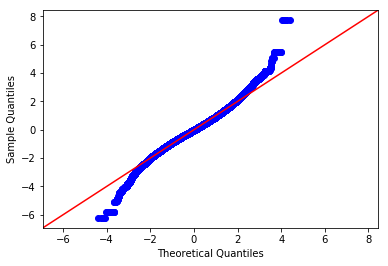

In [1339]:
#Q-Q Plot
residuals = robust_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

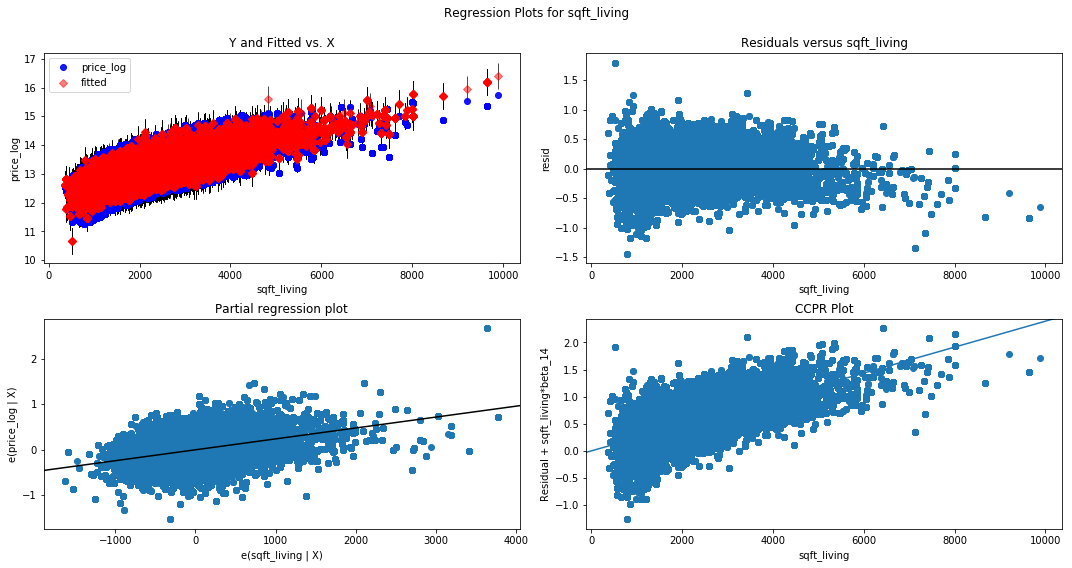

In [1346]:
#Visualize Error Terms
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living' , fig=fig)
plt.show()

In [1291]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(robust_model.resid, robust_model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 6050.717005350512),
 ('p-value', 0.0),
 ('f-value', 249.5066138389156),
 ('f p-value', 0.0)]

In [1292]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_white(robust_model.resid, robust_model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 22544.31532584544),
 ('p-value', 0.0),
 ('f-value', 93.91627769848171),
 ('f p-value', 0.0)]

In [1308]:
# Do boxcox transformations of the continuous variables help?
bc_price, price_lambda = stats.boxcox(df.price)
bc_sqft_living, sqft_living_lambda = stats.boxcox(df.sqft_living)
bc_sqft_living_compare, sqft_living_compare_lambda = stats.boxcox(df.sqft_living_compare)
bc_bedrooms, bedrooms_lambda = stats.boxcox(df.bedrooms)
bc_bathrooms, bathrooms_lambda = stats.boxcox(df.bathrooms)
bc_sqft_lot, sqft_living_compare_lambda = stats.boxcox(df.sqft_living_compare)
bc_house_age, house_age_lambda = stats.boxcox(df.house_age)
bc_condition_stand, condition_stand_lambda = stats.boxcox(df.condition_stand+4)
bc_view_stand, view_stand_lambda = stats.boxcox(df.view_stand + 4)
bc_grade_stand, grade_stand_lambda = stats.boxcox(df.grade_stand + 4)

In [1328]:
# Do boxcox transformations of the continuous variables help?
lambdas = [price_lambda, sqft_living_lambda, sqft_living_compare_lambda, bathrooms_lambda, sqft_living_compare_lambda, house_age_lambda,\
condition_stand_lambda, view_stand_lambda, grade_stand_lambda]

In [1331]:
transformed_df = pd.DataFrame({'price': bc_price,  'house_age': bc_house_age, 'sqft_living': df.sqft_living,\
                               'bathrooms': bc_bathrooms, 'view_stand':bc_view_stand, 'sqft_living_compare':bc_sqft_living_compare, \
                               'condition_stand':bc_condition_stand, 'grade_stand':bc_grade_stand, \
                               'seattle': df.seattle, 'Bedrooms_2': df.Bedrooms_2, 'Bedrooms_3': df.Bedrooms_3, 'Bedrooms_4': df.Bedrooms_4,\
                               'Bedrooms_5': df.Bedrooms_5, 'Bedrooms_6': df.Bedrooms_6, 'Bedrooms_7plus': df.Bedrooms_7plus,\
                                'floors1_5':df.floors1_5, 'floors2':df.floors2, 'floors2_5': df.floors2_5, 'floors3' : df.floors3, 'floors3_5':df.floors3_5\
                                , 'zip_inc_medium_low': df.zip_inc_medium_low, 'zip_inc_medium': df.zip_inc_medium, 'zip_inc_medium_high' : df.zip_inc_medium_high,\
                                 'zip_inc_high':df.zip_inc_high, 'waterfront':df.waterfront, 'price_log': df.price_log, 'view_untrans': df.view_stand
                                })

In [1322]:
# regression is problematic
f = 'price~zip_inc_medium_low+zip_inc_medium+zip_inc_medium_high+zip_inc_high\
+condition_stand+grade_stand+view_stand*waterfront+bathrooms + sqft_living_compare + house_age+seattle+sqft_living\
+Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=transformed_df).fit()
model.summary()

C:\Users\Minotaur142\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -8041.
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               1.00
Time:                        19:44:16   Log-Likelihood:             4.5948e+06
No. Observations:              201045   AIC:                        -9.190e+06
Df Residuals:                  201019   BIC:                        -9.189e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2220   9.19e-13   2.42e+11      0.000       0.222       0.222
zip_inc_medium_low     1.297e-17   1.58e-13   8.18e-05      1.000   -3.11e-13    3.11e-13
zip_inc_medium        -4.095e-15    2.2e-13     -0.019      0.985   -4.35e-13    4.27e-13
zip_inc_medium_high    4.676e-15      3e-13      0.016      0.988   -5.83e-13    5.93e-13
zip_inc_high           2.067e-14   4.29e-12      0.005      0.996   -8.38e-12    8.42e-12
condition_stand       -3.727e-14   2.14e-13     -0.174      0.862   -4.56e-13    3.82e-13
grade_stand           -3.068e-15   3.25e-13     -0.009      0.992    -6.4e-13    6.34e-13
view_stand              1.64e-17   5.24e-20    312.980      0.000    1.63e-17    1.65e-17
waterfront            -8.502e-15   2.73e-12     -0.003      0.998   -5.36e-12    5.35e-12
view_stand:waterfront   2.02e-18   2.24e-19      9.019      0.000    1.58e-18    2.46e-18
bathrooms              8.439e-16   2.02e-13      0.004      0.997   -3.95e-13    3.97e-13
sqft_living_compare    3.349e-16   3.23e-13      0.001      0.999   -6.33e-13    6.33e-13
house_age              1.716e-16   2.44e-14      0.007      0.994   -4.77e-14    4.81e-14
seattle               -1.575e-15   1.84e-13     -0.009      0.993   -3.61e-13    3.58e-13
sqft_living            1.558e-19   1.57e-16      0.001      0.999   -3.08e-16    3.09e-16
Bedrooms_2            -1.431e-15   7.66e-13     -0.002      0.999    -1.5e-12     1.5e-12
Bedrooms_3            -4.227e-16   7.63e-13     -0.001      1.000    -1.5e-12     1.5e-12
Bedrooms_4            -7.836e-16   7.78e-13     -0.001      0.999   -1.53e-12    1.52e-12
Bedrooms_5            -6.192e-16   8.15e-13     -0.001      0.999    -1.6e-12     1.6e-12
Bedrooms_6            -1.739e-15   9.98e-13     -0.002      0.999   -1.96e-12    1.95e-12
Bedrooms_7plus        -4.652e-17   1.58e-12  -2.94e-05      1.000    -3.1e-12     3.1e-12
floors1_5              2.807e-16   2.61e-13      0.001      0.999    -5.1e-13    5.11e-13
floors2                4.841e-17   1.88e-13      0.000      1.000   -3.68e-13    3.68e-13
floors2_5             -1.614e-16   8.85e-13     -0.000      1.000   -1.73e-12    1.73e-12
floors3                -2.61e-16   4.44e-13     -0.001      1.000    -8.7e-13    8.69e-13
floors3_5              2.328e-15    3.6e-12      0.001      0.999   -7.06e-12    7.06e-12
==============================================================================
Omnibus:                   254951.304   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         27232461.773
Skew:                          -7.333   Prob(JB):                         0.00
Kurtosis:                      58.098   Cond. No.                     1.22e+08
==============================================================================

In [1330]:
# Is this because of extreme transformations?
for lmbda in lambdas:
    print(lmbda)

-4.504642305625263
0.044013036912703724
-0.03422483257300629
0.6290828032277511
-0.03422483257300629
0.4826634766593922
0.23767504958691932
8.472135811722177
0.2439335897950297


In [1335]:
f = 'price_log~zip_inc_medium_low+zip_inc_medium+zip_inc_medium_high+zip_inc_high\
+condition_stand+grade_stand+view_untrans*waterfront+bathrooms + sqft_living_compare + house_age+seattle+sqft_living\
+Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=transformed_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                 3.030e+04
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:24:28   Log-Likelihood:                 7770.5
No. Observations:              201045   AIC:                        -1.549e+04
Df Residuals:                  201019   BIC:                        -1.522e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  11.0491      0.007   1473.438      0.000      11.034      11.064
zip_inc_medium_low          0.2516      0.001    195.659      0.000       0.249       0.254
zip_inc_medium              0.5891      0.002    330.295      0.000       0.586       0.593
zip_inc_medium_high         0.5572      0.002    228.692      0.000       0.552       0.562
zip_inc_high                1.1561      0.035     33.259      0.000       1.088       1.224
condition_stand             0.0858      0.002     49.523      0.000       0.082       0.089
grade_stand                 0.4324      0.003    163.868      0.000       0.427       0.438
view_untrans                0.0458      0.001     70.364      0.000       0.044       0.047
waterfront                  0.3102      0.046      6.697      0.000       0.219       0.401
view_untrans:waterfront     0.0436      0.010      4.460      0.000       0.024       0.063
bathrooms                   0.0725      0.002     44.178      0.000       0.069       0.076
sqft_living_compare        -0.1300      0.003    -49.395      0.000      -0.135      -0.125
house_age                   0.0139      0.000     69.728      0.000       0.013       0.014
seattle                     0.4210      0.001    282.665      0.000       0.418       0.424
sqft_living                 0.0002   1.29e-06    185.487      0.000       0.000       0.000
Bedrooms_2                  0.0434      0.006      6.994      0.000       0.031       0.056
Bedrooms_3                  0.0354      0.006      5.718      0.000       0.023       0.048
Bedrooms_4                  0.0380      0.006      6.018      0.000       0.026       0.050
Bedrooms_5                  0.0198      0.007      2.995      0.003       0.007       0.033
Bedrooms_6                 -0.0242      0.008     -2.988      0.003      -0.040      -0.008
Bedrooms_7plus             -0.0879      0.013     -6.858      0.000      -0.113      -0.063
floors1_5                   0.0619      0.002     29.290      0.000       0.058       0.066
floors2                     0.0071      0.002      4.684      0.000       0.004       0.010
floors2_5                   0.0835      0.007     11.647      0.000       0.069       0.098
floors3                     0.0040      0.004      1.126      0.260      -0.003       0.011
floors3_5                  -0.0413      0.029     -1.413      0.158      -0.098       0.016
==============================================================================
Omnibus:                     5880.147   Durbin-Watson:                   0.208
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14901.213
Skew:                           0.083   Prob(JB):                         0.00
Kurtosis:                       4.323   Cond. No.                     2.08e+05
====================

In [1333]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(robust_model.resid, robust_model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 6050.717005350512),
 ('p-value', 0.0),
 ('f-value', 249.5066138389156),
 ('f p-value', 0.0)]

In [1334]:
#Transformations do not solve heteroskedasticity in this case
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_white(robust_model.resid, robust_model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 22544.31532584582),
 ('p-value', 0.0),
 ('f-value', 93.9162776984834),
 ('f p-value', 0.0)]

In [ ]:
"condition_stand","grade_stand",view_untrans*waterfront,bathrooms , sqft_living_compare , house_age,seattle,sqft_living\
,Bedrooms_2,Bedrooms_3,Bedrooms_4,Bedrooms_5,Bedrooms_6,Bedrooms_7plus,floors1_5,floors2,floors2_5,floors3,floors3_5
df = pd.concat([df.reset_index(drop=True), _dummies], axis=1)

In [1348]:
model.outlier_test()

KeyboardInterrupt: 

In [ ]:
#Visualize Error Terms
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living' , fig=fig)
plt.show()

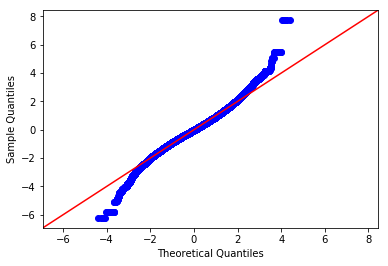

In [1336]:
#Q-Q Plot
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

In [1314]:
df.grade_stand.describe()

count    227052.000000
mean          0.023463
std           0.987653
min          -3.970267
25%          -0.560787
50%          -0.560787
75%           0.291583
max           4.553432
Name: grade_stand, dtype: float64

In [1303]:
df.house_age.describe()

count    227052.000000
mean         42.157501
std          28.391937
min           0.500000
25%          17.500000
50%          38.500000
75%          60.500000
max         115.500000
Name: house_age, dtype: float64

In [1341]:
#testing the two models
#Cross Validation

from sklearn.model_selection import train_test_split
y = transformed_df[['price_log']]
X = transformed_df.drop(['price', 'view_stand'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

NameError: name 'LinearRegression' is not defined

In [716]:
#Create new df of duplicates
dups = pd.DataFrame(df[df.id.duplicated(keep=False)])
#Find percent change in price
dups.sort_values(by=['id','date']).groupby(dups.id).price.pct_change().sort_values(ascending=False) 

11337    3.218009
15712    2.308271
15680    1.969697
16220    1.764706
2723     1.681707
9148     1.536087
228      1.444444
20579    1.371429
6097     1.326531
15547    1.319149
11022    1.311561
15492    1.280000
15130    1.277916
2566     1.261905
10552    1.249166
4526     1.211538
20543    1.205403
20582    1.176636
458      1.130984
191      1.122449
3888     1.114286
9849     0.973913
21405    0.972973
19629    0.950000
15358    0.939163
14507    0.923611
10823    0.917098
21477    0.914286
2667     0.910738
8892     0.897805
           ...   
11056         NaN
3887          NaN
2097          NaN
10047         NaN
2745          NaN
15772         NaN
5260          NaN
21218         NaN
16487         NaN
9362          NaN
8579          NaN
12009         NaN
1353          NaN
1675          NaN
1872          NaN
272           NaN
751           NaN
6142          NaN
10938         NaN
5113          NaN
11005         NaN
3815          NaN
20925         NaN
6232          NaN
12493     

(array([7.500e+01, 6.330e+02, 4.117e+03, 7.230e+03, 6.222e+03, 2.376e+03,
        7.150e+02, 1.860e+02, 3.600e+01, 7.000e+00]),
 array([11.26446411, 11.72369078, 12.18291746, 12.64214414, 13.10137082,
        13.5605975 , 14.01982417, 14.47905085, 14.93827753, 15.39750421,
        15.85673089]),
 <a list of 10 Patch objects>)

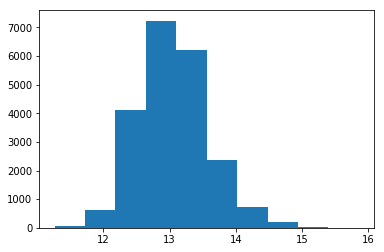

In [159]:
plt.hist(np.log(df.price))

In [382]:
df.zipcode_rank.value_counts()

medium         7783
medium_low     6643
low            6248
medium_high     867
high             50
Name: zipcode_rank, dtype: int64

In [449]:
zipcode_dummies.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  4060000240 2014-06-23  205425.0         2       1.00          880   
2  4058801670 2014-07-17  445000.0         3       2.25         2100   
3  2976800796 2014-09-25  236000.0         3       1.00         1300   
4  6874200960 2015-02-27  170000.0         2       1.00          860   

   sqft_lot  floors  waterfront  view  ...  zipcode_rank_98168  \
0      5650     1.0         NaN   0.0  ...                   0   
1      6780     1.0         0.0   0.0  ...                   0   
2      8201     1.0         NaN   2.0  ...                   0   
3      5898     1.0         NaN   0.0  ...                   0   
4      5265     1.0         0.0   0.0  ...                   0   

   zipcode_rank_98177  zipcode_rank_98178  zipcode_rank_98188  \
0                   0                   1                   0   
1                   0                   1                   0   
2                   0                   1                   0   
3                   0                   1                   0   
4                   0                   1                   0   

   zipcode_rank_98198  zipcode_rank_98199  zipcode_rank_medium_low  \
0                   0                   0                        0   
1                   0                   0                        0   
2                   0                   0                        0   
3                   0                   0                        0   
4                   0                   0                        0   

   zipcode_rank_medium  zipcode_rank_medium_high  zipcode_rank_high  
0                    0                         0                  0  
1                    0                         0                  0  
2                    0                         0                  0  
3                    0                         0                  0  
4                    0                         0                  0  

[5 rows x 100 columns]

In [450]:
df = pd.concat([df.reset_index(drop=True), zipcode_dummies.iloc[:,-4:]], axis=1)

In [413]:
df.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  4060000240 2014-06-23  205425.0         2       1.00          880   
2  4058801670 2014-07-17  445000.0         3       2.25         2100   
3  2976800796 2014-09-25  236000.0         3       1.00         1300   
4  6874200960 2015-02-27  170000.0         2       1.00          860   

   sqft_lot  floors  waterfront  view  ...  view_stand  condition_stand  \
0      5650     1.0         NaN   0.0  ...   -0.305429        -0.629972   
1      6780     1.0         0.0   0.0  ...   -0.305429         0.907199   
2      8201     1.0         NaN   2.0  ...    2.306607        -0.629972   
3      5898     1.0         NaN   0.0  ...   -0.305429        -0.629972   
4      5265     1.0         0.0   0.0  ...   -0.305429        -0.629972   

   grade_stand  house_age  zipcode_price  zipcode_rank  \
0    -0.560787         64      -0.914046           low   
1    -1.413157         74      -0.914046           low   
2     0.291583         52      -0.914046           low   
3    -0.560787         58      -0.914046           low   
4    -1.413157         88      -0.914046           low   

  zipcode_rank_medium_low  zipcode_rank_medium  zipcode_rank_medium_high  \
0                       0                    0                         0   
1                       0                    0                         0   
2                       0                    0                         0   
3                       0                    0                         0   
4                       0                    0                         0   

   zipcode_rank_high  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 33 columns]

In [82]:
f = 'price_log~sqft_living+I(sqft_lot**2)'
model = ols(formula=f, data=df).fit()
model.summary()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  zipcode      lat     long  \
0      5650     1.0         NaN   0.0  ...    98178  47.5112 -122.257   
1      7242     2.0         0.0   0.0  ...    98125  47.7210 -122.319   
2     10000     1.0         0.0   0.0  ...    98028  47.7379 -122.233   
3      5000     1.0         0.0   0.0  ...    98136  47.5208 -122.393   
4      8080     1.0         0.0   0.0  ...    98074  47.6168 -122.045   

  sqft_living15  sqft_lot15  price_log  view_stand  condition_stand  \
0          1340        5650  12.309982   -0.305429        -0.629972   
1          1690        7639  13.195614   -0.305429        -0.629972   
2          2720        8062  12.100712   -0.305429        -0.629972   
3          1360        5000  13.311329   -0.305429         2.444371   
4          1800        7503  13.142166   -0.305429        -0.629972   

   grade_stand  zipcode_price  
0    -0.560787            NaN  
1    -0.560787            NaN  
2    -1.413157            NaN  
3    -0.560787            NaN  
4     0.291583            NaN  

[5 rows x 26 columns]

In [56]:
# sqft_lot demonstrates quadratic behavior, although including it
# and its square barely change goodness of fit metrics
f = 'price_log~sqft_living+sqft_lot+I(sqft_lot**2)'
model = ols(formula=f, data=df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     6769.
Date:                Tue, 18 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:22:15   Log-Likelihood:                -9633.6
No. Observations:               21597   AIC:                         1.928e+04
Df Residuals:                   21593   BIC:                         1.931e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           12.2194      0.006   1917.288      0.000      12.207      12.232
sqft_living          0.0004   2.87e-06    140.423      0.000       0.000       0.000
sqft_lot         -7.797e-07   1.03e-07     -7.557      0.000   -9.82e-07   -5.77e-07
I(sqft_lot ** 2)  8.763e-13    1.4e-13      6.249      0.000    6.01e-13    1.15e-12
==============================================================================
Omnibus:                        3.736   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.702
Skew:                           0.021   Prob(JB):                        0.157
Kurtosis:                       2.952   Cond. No.                     7.46e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.46e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [720]:
len(df)

21596

In [719]:
bc_price_log, price_log_lambda = stats.boxcox(df.price_log)
bc_sqft_living, sqft_living_lambda = stats.boxcox(df.sqft_living)
bc_sqft_above, sqft_above_lambda = stats.boxcox(df.sqft_above)
bc_bedrooms, bedrooms_lambda = stats.boxcox(df.bedrooms)
bc_bathrooms, bathrooms_lambda = stats.boxcox(df.bathrooms)
bc_sqft_lot, sqft_lot_lambda = stats.boxcox(df.sqft_lot)
bc_floors, floors_lambda = stats.boxcox(df.floors)
bc_sqft_living15, sqft_living15_lambda = stats.boxcox(df.sqft_living15)
bc_sqft_lot15, sqft_lot15_lambda = stats.boxcox(df.sqft_lot15)
bc_house_age, house_age_lambda = stats.boxcox(df.house_age)


C:\Users\Minotaur142\Anaconda3\lib\site-packages\scipy\stats\morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
C:\Users\Minotaur142\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2315: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\Minotaur142\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\Minotaur142\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\Minotaur142\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
C:\Users\Minotaur142\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1936: Runt

In [721]:
df_trans = pd.DataFrame({'id':df.id, 'date':df.date, 'waterfront':df.waterfront, 'zipcode':df.zipcode, 'lat':df.lat,\
              'long':df.long, 'view_stand': df.view_stand, 'condition_stand':df.condition_stand, 'grade_stand':df.grade_stand,\
             'zipcode_rank_medium_low':df.zipcode_rank_medium_low, 'zipcode_rank_medium':df.zipcode_rank_medium,\
              'zipcode_rank_medium_high':df.zipcode_rank_medium_high, 'zipcode_rank_high':df.zipcode_rank_high,\
              'price_log':df.price_log, 'sqft_living':bc_sqft_living, 'sqft_above':bc_sqft_above, 'bedrooms':bc_bedrooms,
              'bathrooms':bc_bathrooms, 'sqft_lot':bc_sqft_lot, 'floors':bc_floors, 'sqft_living15': bc_sqft_living15,\
             'sqft_lot15':bc_sqft_lot15, 'house_age':bc_house_age})

In [453]:
price_log_lambda 
sqft_living_lambda
sqft_above_lambda
bedrooms_lambda 
bathrooms_lambda 
sqft_lot_lambda 
floors_lambda 
sqft_living15_lambda 
sqft_lot15_lambda 
house_age_lambda 

0.47127038952532874

In [722]:
f = 'price_log~zipcode_rank_medium_low+zipcode_rank_medium+zipcode_rank_medium_high+zipcode_rank_high\
                +view_stand+condition_stand+grade_stand+sqft_living+waterfront + sqft_lot'
model = ols(formula=f, data=df_trans).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     7365.
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:42:46   Log-Likelihood:                -595.20
No. Observations:               19163   AIC:                             1210.
Df Residuals:                   19153   BIC:                             1289.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -3.056e+10   8.35e+10     -0.366      0.714   -1.94e+11    1.33e+11
zipcode_rank_medium_low      0.3571      0.005     76.104      0.000       0.348       0.366
zipcode_rank_medium          0.5839      0.005    124.100      0.000       0.575       0.593
zipcode_rank_medium_high     0.9486      0.010     94.950      0.000       0.929       0.968
zipcode_rank_high            1.3194      0.038     35.103      0.000       1.246       1.393
view_stand                   0.0770      0.002     37.584      0.000       0.073       0.081
condition_stand              0.0428      0.002     23.159      0.000       0.039       0.046
grade_stand                  0.2690      0.002    133.632      0.000       0.265       0.273
sqft_living               1.328e+11   3.63e+11      0.366      0.714   -5.78e+11    8.44e+11
waterfront                   0.4062      0.023     17.818      0.000       0.362       0.451
sqft_lot                  1.327e+11   3.62e+11      0.366      0.714   -5.78e+11    8.43e+11
==============================================================================
Omnibus:                      403.219   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              878.194
Skew:                           0.053   Prob(JB):                    2.01e-191
Kurtosis:                       4.043   Cond. No.                     2.07e+29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.85e-55. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [550]:
f = 'price_log~Bedrooms_2+Bedrooms_3+Bedrooms_4+Bedrooms_5+Bedrooms_6+Bedrooms_7plus'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     102.6
Date:                Thu, 20 Jun 2019   Prob (F-statistic):          8.09e-128
Time:                        11:44:03   Log-Likelihood:                -16488.
No. Observations:               21595   AIC:                         3.299e+04
Df Residuals:                   21588   BIC:                         3.305e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.7882      0.037    344.764      0.000      12.716      12.861
Bedrooms_2         0.1726      0.038      4.495      0.000       0.097       0.248
Bedrooms_3         0.2033      0.037      5.427      0.000       0.130       0.277
Bedrooms_4         0.3337      0.038      8.871      0.000       0.260       0.407
Bedrooms_5         0.4414      0.039     11.232      0.000       0.364       0.518
Bedrooms_6         0.3736      0.049      7.678      0.000       0.278       0.469
Bedrooms_7plus     0.5838      0.076      7.668      0.000       0.435       0.733
==============================================================================
Omnibus:                      842.565   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1107.987
Skew:                           0.415   Prob(JB):                    2.53e-241
Kurtosis:                       3.736   Cond. No.                         34.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [529]:
f = 'price_log~floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     558.1
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:29:08   Log-Likelihood:                -15479.
No. Observations:               21596   AIC:                         3.097e+04
Df Residuals:                   21590   BIC:                         3.102e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8758      0.005   2684.070      0.000      12.866      12.885
floors1_5      0.2358      0.012     19.150      0.000       0.212       0.260
floors2        0.3598      0.007     49.499      0.000       0.346       0.374
floors2_5      0.7907      0.039     20.094      0.000       0.714       0.868
floors3        0.2928      0.021     14.205      0.000       0.252       0.333
floors3_5      0.5332      0.187      2.846      0.004       0.166       0.900
==============================================================================
Omnibus:                      820.957   Durbin-Watson:                   0.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1028.783
Skew:                           0.425   Prob(JB):                    4.01e-224
Kurtosis:                       3.648   Cond. No.                         60.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [548]:
f = 'price_log~sqft_living+floors1_5+floors2+floors2_5+floors3+floors3_5'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     3567.
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:40:40   Log-Likelihood:                -9354.4
No. Observations:               21596   AIC:                         1.872e+04
Df Residuals:                   21589   BIC:                         1.878e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.1896      0.006   1889.442      0.000      12.177      12.202
sqft_living     0.0004   3.08e-06    128.371      0.000       0.000       0.000
floors1_5       0.1664      0.009     17.913      0.000       0.148       0.185
floors2         0.0276      0.006      4.562      0.000       0.016       0.039
floors2_5       0.2312      0.030      7.719      0.000       0.173       0.290
floors3         0.2703      0.016     17.413      0.000       0.240       0.301
floors3_5       0.2531      0.141      1.793      0.073      -0.024       0.530
==============================================================================
Omnibus:                       14.039   Durbin-Watson:                   0.776
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.338
Skew:                           0.023   Prob(JB):                     0.000467
Kurtosis:                       3.122   Cond. No.                     1.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [553]:
zips2 = df.loc[:,['zipcode', 'price']]

In [554]:
zips2.groupby(zips2.zipcode)

In [585]:
dfzip = df.set_index([df.zipcode, df.index])


count                   21591
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

In [838]:
dfzip = df.set_index([df.zipcode, df.index])

In [1024]:
zips_dict = dict.fromkeys(df.zipcode)
for i in zips_dict.keys():
    zips_dict[i] = list(dfzip.loc[i].price)
df['zip_price_list'] = df['zipcode'].map(zips_dict)
[i[1:] for i in df['zip_price_list']]
df['zipcode_median'] = [np.median(i) for i in df['zip_price_list']]

[[445000.0,
  236000.0,
  170000.0,
  245000.0,
  165000.0,
  239900.0,
  339000.0,
  290900.0,
  190000.0,
  260000.0,
  360000.0,
  289500.0,
  188000.0,
  350000.0,
  164808.0,
  310000.0,
  825000.0,
  269000.0,
  252500.0,
  790000.0,
  260000.0,
  245000.0,
  1700000.0,
  612000.0,
  285000.0,
  299000.0,
  212000.0,
  240000.0,
  255000.0,
  335000.0,
  194000.0,
  251700.0,
  150000.0,
  280005.0,
  243000.0,
  400000.0,
  355000.0,
  294000.0,
  210000.0,
  184500.0,
  199000.0,
  415000.0,
  285000.0,
  200000.0,
  700000.0,
  178000.0,
  160000.0,
  100000.0,
  330000.0,
  355000.0,
  119900.0,
  200000.0,
  345100.0,
  200000.0,
  210000.0,
  359950.0,
  360000.0,
  265000.0,
  195000.0,
  353000.0,
  499900.0,
  169000.0,
  220000.0,
  279000.0,
  372500.0,
  235000.0,
  1100000.0,
  258000.0,
  241000.0,
  261000.0,
  390000.0,
  375000.0,
  352000.0,
  287000.0,
  241000.0,
  295000.0,
  800000.0,
  375000.0,
  212000.0,
  350000.0,
  336000.0,
  303100.0,
  356200.0,
  

In [1033]:
ziplists = df.

0    279000.0
1    425000.0
2    445500.0
3    487475.0
4    643250.0
Name: zipcode_median, dtype: float64

In [959]:
prices = df.price.tolist()

In [1146]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_log',
       'sqft_living_compare', 'view_stand', 'condition_stand', 'grade_stand',
       'house_age', 'bath_per_bed', 'sqft_per_bed', 'zip_price_list',
       'zipcode_median', 'median_income_2014', 'mean_income_2014',
       'median_income__2014_rank', 'median_income_2014_rank',
       '2014_inc_medium_low', '2014_inc_medium', '2014_inc_medium_high',
       '2014_inc_high', 'zip_median_rank', 'zip_median_medium_low',
       'zip_median_medium', 'zip_median_medium_high', 'zip_median_high',
       'seattlezip'],
      dtype='object')

In [1086]:
income = pd.read_csv(r"")
income['zipcode'] = df.zipcode.astype(str)
income['median_income_2014'] = income.median_income_2014.to_numeric()
df = df.merge(income, on='zipcode', how='left')

In [1065]:
income['zipcode'] = df.zipcode.astype(str)

In [1066]:
income['median_income_2014'] = df.zipcode.to_numeric()

'98178'

In [1201]:
df.seattle.value_counts()

0    156098
1     70954
Name: seattle, dtype: int64